In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def export_figure (title):
    plt.tight_layout()
    plt.savefig(os.path.join("figs", title + ".eps"))
    plt.show()

In [183]:
def make_code_columns(raw_coded):
    meta_cols = []
    coder_cols = []
    renamer = {}
    for col in raw_coded.columns:
        shortened = col
        if col[0:3] == "[M]":
            shortened = col[4:-2]
            meta_cols.append(shortened)
        if col[0:3] == "[C]":
            shortened = col[3:]
            coder_cols.append(shortened)
        renamer[col] = shortened


    # first two meta columns are elective code and institution, which we use as the index
    # third meta column is title
    index_cols = meta_cols[0:3]
    keep_cols = index_cols + coder_cols
    base = raw_coded.rename(columns=renamer)[keep_cols]

    long1 = base.melt(index_cols)
    long1.value = long1.value.str.replace(" ","")
    long1.value = long1.value.str.pad(width=2, side='left', fillchar='0')
    long1.value = long1.value.str.replace("00","")

    long2 = long1.join(long1['value'].str.split(';', expand=True))
    long3 = long2.drop('value', axis=1)
    long3 = long3.rename(columns={'variable': 'coder'})

    long4 = long3.melt(index_cols + ['coder'])
    long4 = long4.rename(columns={'value': 'code'})[index_cols + ['coder','code']]
    long4.fillna("",inplace = True)
    long4 = long4[long4.code.str.len()>0]

    long5 = long4.groupby(index_cols + ['code']).count().unstack().fillna(0)
    long5.columns = long5.columns.get_level_values(1)
    return long5



In [184]:
def has_agreement_inset_code(code_in_columns, value_set, code):
    return code_in_columns[code].isin(value_set)

def has_agreement_inset_any_code(code_in_columns, value_set):
    has_agreement = False
    for col in code_in_columns.columns:
        has_agreement = has_agreement | has_agreement_inset_code(code_in_columns, value_set, col)
    return has_agreement

def has_agreement_4_plus_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [4,5,6,7], code)

def has_agreement_23_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [2,3], code)

def has_agreement_4_plus_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [4,5,6,7])

def has_agreement_23_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [2,3])

def has_overall_agreement_code(code_in_columns, code):
    return (has_agreement_4_plus_code(code_in_columns, code)) & ~(has_agreement_23_code(code_in_columns, code))

def has_overall_agreement_any_code(code_in_columns):
    return (has_agreement_4_plus_any_code(code_in_columns)) & ~(has_agreement_23_any_code(code_in_columns))


In [185]:
#dump_file = "20230612WG6_Trial_Sample50-export-20230616-013559.csv"
#dump_file = "20230622WG6_AllElectivesPart1-export-20230702-050135.csv"
#dump_file = "20230622WG6_AllElectivesPart2-export-20230702-050210.csv"
#dump_file = "20230622WG6_AllElectivesPart1-export-20230705-123616.csv"
stage_one_files = ["20230622WG6_AllElectivesPart1-stage1.csv", "20230622WG6_AllElectivesPart2-stage1.csv", "20230622WG6_AllElectivesPart3-stage1.csv"]

stage_one_contents = []
for stage_one_file in stage_one_files:
    raw = pd.read_csv(os.path.join("coded", stage_one_file), dtype='string').fillna("")
    stage_one_contents.append(raw)
raw_coded = pd.concat(stage_one_contents)
raw_coded.to_csv(os.path.join("coded","stage1_codes_raw.csv"))

code_in_columns = make_code_columns(raw_coded)
code_in_columns.to_csv(os.path.join("coded","stage1_codes_columns.csv"))

In [186]:
stage_two = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"))

key_columns = ['institution', 'elective']
print(len(stage_two.columns))
stage_two_files = ["stage2_codes_columns-DM.csv", "stage2_codes_columns-SDF.csv", "stage2_codes_columns-AL.csv", "stage2_codes_columns-SE-SP.csv", "stage2_codes_columns-SPD.csv"]
for stage_two_file in stage_two_files:
    stage_two_addition = pd.read_csv(os.path.join("coded", "stage2", stage_two_file), dtype='string').fillna("")
    updated_columns = list(set(stage_two_addition.columns) - set(key_columns))
    print (updated_columns, "updated columns for ", stage_two_file)
    joined = stage_two.merge(stage_two_addition, on=['institution','elective'], how='left')
    for updated_column in updated_columns:
        joined[updated_column] = joined[updated_column+"_y"].astype('float')*7
        joined.drop(columns=[updated_column + "_x", updated_column + "_y"], inplace=True)
    stage_two = joined.fillna(0)
#    print(joined.describe())
    
stage_two.to_csv(os.path.join("coded","stage2_codes_columns.csv"))

38
['DM'] updated columns for  stage2_codes_columns-DM.csv
['SDF'] updated columns for  stage2_codes_columns-SDF.csv
['AL'] updated columns for  stage2_codes_columns-AL.csv
['SE', 'SEP'] updated columns for  stage2_codes_columns-SE-SP.csv
['SPD'] updated columns for  stage2_codes_columns-SPD.csv


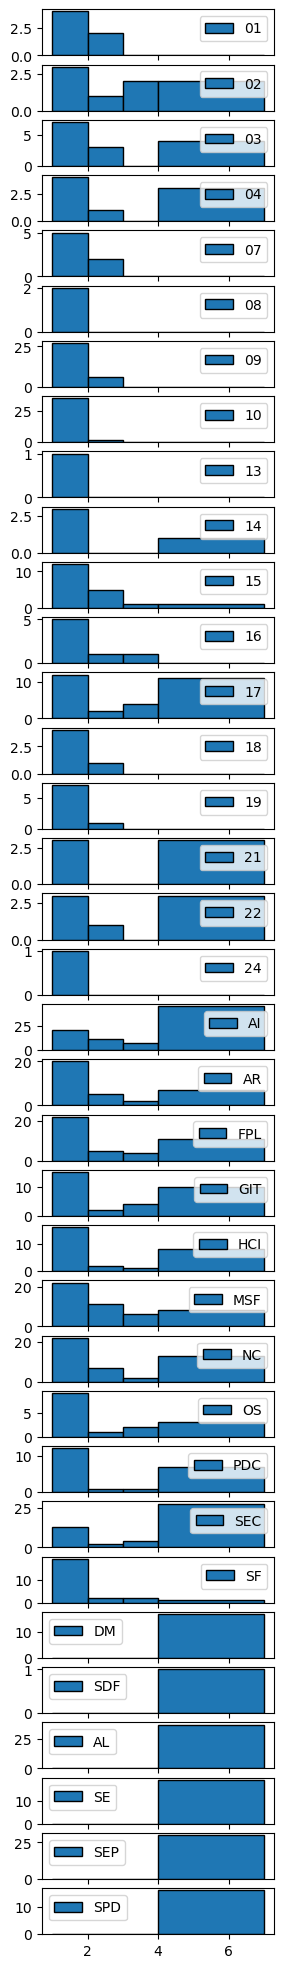

In [207]:
cols_to_plot = stage_two.columns[3:]

fig, axs = plt.subplots(len(cols_to_plot), figsize=(3, 25))
for n, col in enumerate(cols_to_plot):
    stage_two[col].replace(0, np.nan).hist(ax=axs[n], bins=[1,2,3,4,7],  edgecolor='black', grid=False, legend=True)



In [11]:
def electives_with_codes(codes):
    code_in_columns = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"))
    has_a_code = False
    for code in codes:
        has_a_code = has_a_code | (code_in_columns[code] > 0)
    index_of_electives_with_code = code_in_columns[has_a_code][['institution','elective','title']]
    def row_included(row):
        this_inst = row.institution
        this_elective = row.elective
        return index_of_electives_with_code[(index_of_electives_with_code.institution == this_inst) &
                                           (index_of_electives_with_code.elective == this_elective)]['elective'].count() >0
    all_electives = pd.read_csv("all_electives.csv")
    return all_electives[all_electives.apply(row_included, axis=1)]
#    return all_electives.apply(row_included, axis=1)

In [17]:
DM = electives_with_codes(["DM"])
DM.to_csv("coded/electives_with_codes-DM.csv")

In [7]:
all_electives = pd.read_csv("all_electives.csv")
all_electives

,institution,elective,overview,title,summary,content,ilo
0,Durham_England,COMP3421,<h2>Durham_England COMP3421</h2><h2>title</h2>...,COMP3421: \nCOMPUTER SCIENCE INTO SCHOOLS,\n\t\t\t<li>To develop a range of key skills i...,\n\t\t\t<li>A competitive interview system wil...,\n\t\t\t\t<li>On successful completion of this...
1,Durham_England,COMP3477,<h2>Durham_England COMP3477</h2><h2>title</h2>...,COMP3477: \nALGORITHMIC GAME THEORY,\n\t\t\t<li> The aim of the module is to intro...,\n\t\t\t<li>Introduction to Game Theory: what ...,"\n\t\t\t\t<li>On completion of the module, stu..."
2,Durham_England,COMP3487,<h2>Durham_England COMP3487</h2><h2>title</h2>...,COMP3487: \nBIOINFORMATICS,\n\t\t\t<li>To introduce students to applicati...,\n\t\t\t<li>Dynamic programming algorithms for...,"\n\t\t\t\t<li>On completion of the module, stu..."
3,Durham_England,COMP3467,<h2>Durham_England COMP3467</h2><h2>title</h2>...,COMP3467: \nADVANCED COMPUTER SYSTEMS,\n\t\t\t<li> To provide understanding of the r...,\n\t\t\t<li> Computer Architecture including c...,"\n\t\t\t\t<li>On completion of the module, stu..."
4,Durham_England,COMP3491,<h2>Durham_England COMP3491</h2><h2>title</h2>...,COMP3491: \nCODES AND CRYPTOGRAPHY,\n\t\t\t<li>To give an introduction to the fun...,\n\t\t\t<li>Data compression: lossless compres...,"\n\t\t\t\t<li>On completion of the module, stu..."
...,...,...,...,...,...,...,...
270,VirginiaTech_USA,CS4704,<h2>VirginiaTech_USA CS4704</h2><h2>title</h2>...,Software Engineering Capstone,NaN,Senior project course integrating software eng...,NaN
271,VirginiaTech_USA,CS4784,<h2>VirginiaTech_USA CS4784</h2><h2>title</h2>...,Human-Computer Interaction Capstone,NaN,"Advanced, project-based course in Human-Comput...",NaN
272,VirginiaTech_USA,CS4804,<h2>VirginiaTech_USA CS4804</h2><h2>title</h2>...,Introduction to Artificial Intelligence,NaN,"Overview of the areas of problem solving, game...",NaN
273,VirginiaTech_USA,CS4824,<h2>VirginiaTech_USA CS4824</h2><h2>title</h2>...,Machine Learning,NaN,Algorithms and principles involved in machine ...,NaN
